# Urban heat island (UHI) regression

In [ ]:
import itertools

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spreg
import xarray as xr

from uhi_cws_lausanne import regr_utils

np.random.seed(0)
sns.set_style("whitegrid")

In [ ]:
stations_gdf_filepath = "../data/processed/stations.gpkg"
station_features_filepath = "../data/processed/stations-features.csv"
ts_df_filepath = "../data/processed/ts-df.csv"
grid_gdf_filepath = "../data/processed/regular-grid.gpkg"
grid_features_filepath = "../data/processed/grid-features.csv"

# output plots
dst_regr_plot_filepath = "../reports/figures/regr-plot.pdf"
dst_regr_betas_filepath = "../reports/figures/regr-betas.pdf"
dst_regr_maps_filepath = "../reports/figures/regr-maps.png"

# hour_range = range(0, 24, 3)
target_hour = 21
# target_var_label = "UHI$_{mean}$ ($^{\circ}$C)"
# max_nan_at_target_hour = 0.2

exclude_features = [
    f"{feature}_{scale}"
    for feature, scale in itertools.product(
        ["northness", "slope", "tpi"], ["25", "50", "100"]
    )
]

# n_repetitions = 10
# test_size = 0.33

# for plots
col_wrap = 3
obs_label = "UHI$_{obs}$ [$^{\circ}$C]"
pred_label = "UHI$_{pred}$ [$^{\circ}$C]"
figwidth = plt.rcParams["figure.figsize"][0]
figheight = plt.rcParams["figure.figsize"][1]
feature_label_dict = {
    "building_volume_100": "Building volume (100 m)",
    "building_volume_250": "Building volume (250 m)",
    "building_volume_500": "Building volume (500 m)",
    "elevation": "Elevation",
    "lake_dist": "Distance to lake",
    "northness_250": "Northness (250 m)",
    "northness_500": "Northness (500 m)",
    "slope_250": "Slope (250 m)",
    "slope_500": "Slope (500 m)",
    "tpi_250": "TPI (250 m)",
    "tpi_500": "TPI (500 m)",
    "tree_canopy_100": "Tree canopy (100 m)",
    "tree_canopy_250": "Tree canopy (250 m)",
    "tree_canopy_500": "Tree canopy (500 m)",
}

## Load data

In [ ]:
station_features_gdf = gpd.read_file(stations_gdf_filepath)
# get the station id column label
station_id_col = station_features_gdf.columns.difference(["geometry", "source"])[0]
# read the station features and merge them based on the station id column
station_features_gdf = station_features_gdf.merge(
    pd.read_csv(station_features_filepath), on=station_id_col
)
# useful to use below
feature_cols = station_features_gdf.columns.difference(
    ["geometry", "source", station_id_col]
)
# set the station id as index
station_features_gdf = station_features_gdf.set_index(station_id_col)
# # drop stations with nan values (important for the regression)
# station_features_gdf = station_features_gdf.dropna(axis="index", subset=feature_cols)
# drop features at small scales
station_features_gdf = station_features_gdf.loc[
    :,
    ~(
        station_features_gdf.columns.str.endswith("_25")
        | station_features_gdf.columns.str.endswith("_50")
        | station_features_gdf.columns.str.startswith("building_area")
    ),
].drop(columns=exclude_features, errors="ignore")
# show the data frame
station_features_gdf.head()

,source,geometry,building_volume_100,building_volume_250,building_volume_500,tree_canopy_100,tree_canopy_250,tree_canopy_500,slope_250,slope_500,northness_250,northness_500,tpi_250,tpi_500,elevation,lake_dist
station_id,,,,,,,,,,,,,,,,
NABLAU,Official,POINT (2539020 1152974),4.125657e+06,2.547040e+08,4.804493e+09,0.071970,0.083270,0.101137,0.144186,0.177705,-0.361542,-0.312035,0.829834,9.341858,577.88040,2180.436846
PUY,Official,POINT (2540819 1151510),3.492351e+06,1.908322e+08,3.169833e+09,0.038706,0.098202,0.108252,0.176746,0.224837,-0.636290,-0.532102,-0.696106,4.946564,455.29044,755.631427
WSLLAF,Official,POINT (2539058 1156741),0.000000e+00,2.015655e+06,1.712379e+08,0.066272,0.030899,0.051662,0.110623,0.148837,-0.127812,-0.092798,-2.650940,-1.232178,755.43830,5845.328440
VD_Lausanne_PdL,Official,POINT (2537375 1154164),2.010137e+06,9.073344e+07,2.040286e+09,0.047142,0.077296,0.091048,0.091237,0.121033,-0.367936,-0.191801,-1.391418,3.981079,597.27875,2819.677957
VD_Bussigny,Official,POINT (2532800 1155659),3.961911e+06,1.490493e+08,2.292667e+09,0.053667,0.063621,0.068894,0.095105,0.104195,-0.264232,-0.313744,-0.400757,2.394074,429.82294,3702.175319


In [ ]:
ts_df = pd.read_csv(
    ts_df_filepath, index_col=["heatwave", "time"], parse_dates=["time"]
).rename_axis(columns=station_features_gdf.index.name)
# filter target hour only
ts_df = ts_df.loc[
    (slice(None), ts_df.index.get_level_values("time").hour == target_hour), :
]
# show data frame
ts_df.head()

station_id                                    NABLAU        PUY     WSLLAF  \
heatwave              time                                                   
2023/07/09-2023/07/11 2023-07-09 21:00:00  26.583333  26.000000  25.533333   
                      2023-07-10 21:00:00  27.883333  26.733333  23.650000   
                      2023-07-11 21:00:00  23.716667  23.300000  21.200000   
2023/08/18-2023/08/25 2023-08-18 21:00:00  25.916667  25.166667  25.650000   
                      2023-08-19 21:00:00  27.733333  26.766667  25.283333   

station_id                                 VD_Lausanne_PdL  VD_Bussigny  \
heatwave              time                                                
2023/07/09-2023/07/11 2023-07-09 21:00:00          27.6245      26.3410   
                      2023-07-10 21:00:00          27.9945      29.3590   
                      2023-07-11 21:00:00          20.3305      23.1095   
2023/08/18-2023/08/25 2023-08-18 21:00:00          26.3300      26.1190   
                      2023-08-19 21:00:00          28.2435      28.8485   

station_id                                 VD_Morges  Nabel_Lausanne  PULLY  \
heatwave              time                                                    
2023/07/09-2023/07/11 2023-07-09 21:00:00    28.4815       28.603986   27.9   
                      2023-07-10 21:00:00    28.8355       29.354611   28.4   
                      2023-07-11 21:00:00    25.4290       21.607236   21.8   
2023/08/18-2023/08/25 2023-08-18 21:00:00    27.1540       28.523499   27.4   
                      2023-08-19 21:00:00    30.4200       30.216319   29.7   

station_id                                 MARCELIN  BOURG-EN-LAVAUX  ...  \
heatwave              time                                            ...   
2023/07/09-2023/07/11 2023-07-09 21:00:00      25.6             27.8  ...   
                      2023-07-10 21:00:00      26.2             28.6  ...   
                      2023-07-11 21:00:00      24.3             22.0  ...   
2023/08/18-2023/08/25 2023-08-18 21:00:00      25.1             28.6  ...   
                      2023-08-19 21:00:00      28.9             29.5  ...   

station_id                                 70:ee:50:80:21:5e  \
heatwave              time                                     
2023/07/09-2023/07/11 2023-07-09 21:00:00               25.7   
                      2023-07-10 21:00:00               27.6   
                      2023-07-11 21:00:00               22.9   
2023/08/18-2023/08/25 2023-08-18 21:00:00               24.8   
                      2023-08-19 21:00:00               27.8   

station_id                                 70:ee:50:83:dd:c6  \
heatwave              time                                     
2023/07/09-2023/07/11 2023-07-09 21:00:00               24.6   
                      2023-07-10 21:00:00               25.5   
                      2023-07-11 21:00:00               21.2   
2023/08/18-2023/08/25 2023-08-18 21:00:00               23.8   
                      2023-08-19 21:00:00               26.1   

station_id                                 70:ee:50:84:02:60  \
heatwave              time                                     
2023/07/09-2023/07/11 2023-07-09 21:00:00               24.2   
                      2023-07-10 21:00:00               25.6   
                      2023-07-11 21:00:00               22.0   
2023/08/18-2023/08/25 2023-08-18 21:00:00               24.0   
                      2023-08-19 21:00:00               26.1   

station_id                                 70:ee:50:84:93:2c  \
heatwave              time                                     
2023/07/09-2023/07/11 2023-07-09 21:00:00               24.1   
                      2023-07-10 21:00:00               25.7   
                      2023-07-11 21:00:00               21.0   
2023/08/18-2023/08/25 2023-08-18 21:00:00               22.0   
                      2023-08-19 21:00:00               26.4   

station_id                           

In [ ]:
# 1. using official stations only
official_gdf = station_features_gdf[station_features_gdf["source"] == "Official"].drop(
    columns="source"
)
official_y_ser = (
    ts_df[official_gdf.index].apply(lambda row: row - row.min(), axis="columns").stack()
)
official_regr = regr_utils.Regressor(
    official_gdf, official_y_ser.droplevel(["heatwave", "time"])
)
# ACHTUNG: `tol=0.02` is hardcoded after being found by trial and error to be the lowest
# value that brings the multicollinearity condition number under 10
# TODO: find an automated procedure to do this
official_sfs = official_regr.sequential_feature_selector(tol=0.02)
official_features = official_regr.X_df.columns[official_sfs.get_support()]
official_ols = official_regr.fit_model(features=official_features)
print(official_ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         110
Mean dependent var  :      2.8154                Number of Variables   :           5
S.D. dependent var  :      1.6836                Degrees of Freedom    :         105
R-squared           :      0.3712
Adjusted R-squared  :      0.3472
Sum squared residual:     194.288                F-statistic           :     15.4929
Sigma-square        :       1.850                Prob(F-statistic)     :   5.434e-10
S.E. of regression  :       1.360                Log likelihood        :    -187.371
Sigma-square ML     :       1.766                Akaike info criterion :     384.741
S.E of regression ML:      1.3290                Schwarz criterion     :     398.243

------------------------------------------------------------

In [ ]:
# 2. using official + CWS
y_ser = ts_df.apply(lambda row: row - row.min(), axis="columns").stack().dropna()
regr = regr_utils.Regressor(
    station_features_gdf.drop(columns="source"), y_ser.droplevel(["heatwave", "time"])
)
# ACHTUNG: `tol=0.002` is hardcoded after being found by trial and error to be the
# lowest value that brings the multicollinearity condition number under 10
# TODO: find an automated procedure to do this
sfs = regr.sequential_feature_selector(tol=0.002)
features = regr.X_df.columns[sfs.get_support()]
ols = regr.fit_model(features=features)
print(ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         998
Mean dependent var  :      3.4953                Number of Variables   :           9
S.D. dependent var  :      1.5237                Degrees of Freedom    :         989
R-squared           :      0.3297
Adjusted R-squared  :      0.3243
Sum squared residual:      1551.7                F-statistic           :     60.7998
Sigma-square        :       1.569                Prob(F-statistic)     :   9.292e-81
S.E. of regression  :       1.253                Log likelihood        :   -1636.336
Sigma-square ML     :       1.555                Akaike info criterion :    3290.672
S.E of regression ML:      1.2469                Schwarz criterion     :    3334.824

------------------------------------------------------------

In [ ]:
lag = regr.fit_model(model_class=spreg.OLS, features=features, slx_lags=1)
print(lag.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES WITH SPATIALLY LAGGED X (SLX)
-----------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         998
Mean dependent var  :      3.4953                Number of Variables   :          17
S.D. dependent var  :      1.5237                Degrees of Freedom    :         981
R-squared           :      0.3770
Adjusted R-squared  :      0.3668
Sum squared residual:     1442.23                F-statistic           :     37.0969
Sigma-square        :       1.470                Prob(F-statistic)     :   2.568e-89
S.E. of regression  :       1.213                Log likelihood        :   -1599.827
Sigma-square ML     :       1.445                Akaike info criterion :    3233.655
S.E of regression ML:      1.2021                Schwarz criterion     :    3317.052



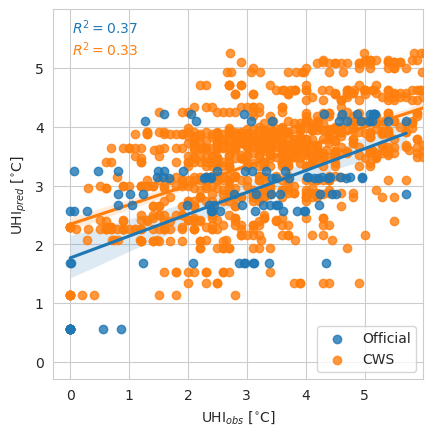

In [ ]:
# comparison regression plot
colors = sns.color_palette()
fig, ax = plt.subplots()
for i, (_regr, model, color, label, zorder) in enumerate(
    zip(
        [official_regr, regr], [official_ols, ols], colors, ["Official", "CWS"], [10, 5]
    )
):
    zorder_dict = {"zorder": zorder}
    _regr.regplot(
        model.predy.flatten(),
        obs_label=obs_label,
        pred_label=pred_label,
        color=color,
        label=label,
        ax=ax,
        scatter_kws=zorder_dict,
        line_kws=zorder_dict,
    )
    ax.text(
        0.05,
        0.935 - i * 0.06,
        rf"$R^2 = {model.r2:.2}$",
        color=color,
        transform=ax.transAxes,
    )
ax.legend()
fig.savefig(dst_regr_plot_filepath, bbox_inches="tight")

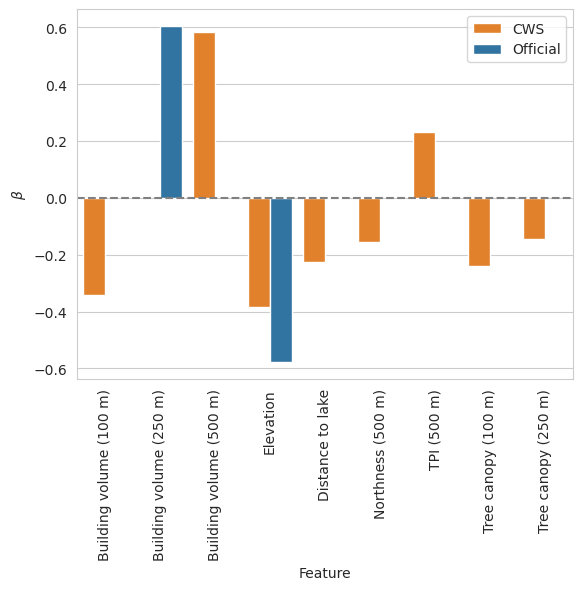

In [ ]:
official_coeff_df = regr_utils.coeff_df(official_ols)
# lag_coeff_df = coeff_df(lag, test_attr="z_stat")
coeff_df = regr_utils.coeff_df(ols)
# # discard the spatial lag coefficients
# lag_coeff_df = lag_coeff_df[~lag_coeff_df["feature"].str.startswith("W_")]

significant_features = set(
    official_coeff_df[official_coeff_df["p"] <= 0.05]["feature"]
).union(coeff_df[coeff_df["p"] <= 0.05]["feature"])

plot_df = pd.concat(
    [
        _coeff_df[_coeff_df["feature"].isin(significant_features)].assign(
            **{"source": label}
        )
        for _coeff_df, label in zip([official_coeff_df, coeff_df], ["Official", "CWS"])
    ]
).sort_values("feature")
plot_df["feature"] = plot_df["feature"].map(feature_label_dict)
plot_df = plot_df.rename(columns={"beta": r"$\beta$", "feature": "Feature"})

fig, ax = plt.subplots()
sns.barplot(
    plot_df,
    x="Feature",
    y=r"$\beta$",
    hue="source",
    # ACHTUNG: ugly hardcoded
    palette=reversed(sns.color_palette(n_colors=2)),
    ax=ax,
)
# remove legend title
ax.legend().set_title("")
# add a horizontal line at 0
ax.axhline(0, color="gray", linestyle="--")
# rotate the x-axis labels
ax.tick_params(axis="x", labelrotation=90)
# save figure
fig.savefig(dst_regr_betas_filepath, bbox_inches="tight")

In [ ]:
# TODO: DRY
# out of sample prediction
grid_features_gdf = gpd.read_file(grid_gdf_filepath)
# get the grid cell id column label
grid_id_col = grid_features_gdf.columns.difference(["geometry"])[0]
# read the grid features and merge them based on the grid cell id column
grid_features_gdf = grid_features_gdf.merge(
    pd.read_csv(grid_features_filepath), on=grid_id_col
)
# drop features at small scales
grid_features_gdf = grid_features_gdf.loc[
    :,
    ~(
        grid_features_gdf.columns.str.endswith("_25")
        | grid_features_gdf.columns.str.endswith("_50")
        | grid_features_gdf.columns.str.startswith("building_area")
    ),
].drop(columns=exclude_features, errors="ignore")
# set the grid cell id as index
grid_features_gdf = grid_features_gdf.set_index(grid_id_col)

In [ ]:
official_pred_da = official_regr.predict_raster(
    official_ols,
    grid_features_gdf,
    features=official_features,
    pred_label=pred_label,
)

In [ ]:
# grid_w = regr_utils.weights_from_gser(grid_features_gdf["geometry"])
# pred_da = regr.predict_raster(
#     lag,
#     grid_features_gdf,
#     features=features,
#     w=grid_w,
#     pred_label=pred_label,
# )
pred_da = regr.predict_raster(
    ols,
    grid_features_gdf,
    features=features,
    pred_label=pred_label,
)

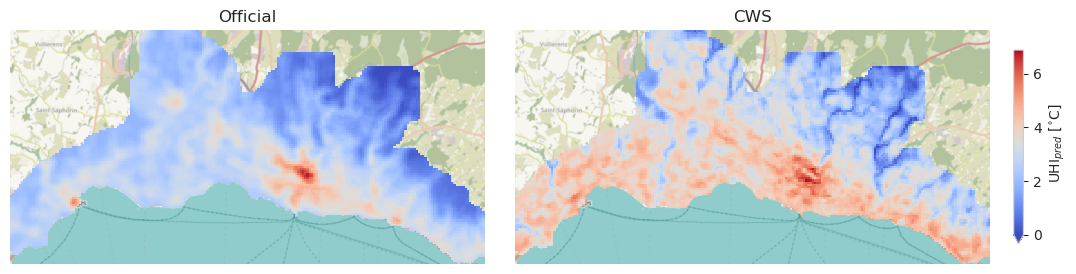

In [ ]:
vmin = 0
# vmax = max(pred_da.max(), official_pred_da.max())
vmax = pred_da.max()
p = xr.concat(
    [official_pred_da, pred_da], pd.Index(["Official", "CWS"], name="source")
).plot(
    col="source",
    vmin=vmin,
    vmax=vmax,
    cmap="coolwarm",
    cbar_kwargs={"shrink": 0.5, "pad": 0.02},
    figsize=(figwidth * 2, figheight),
)
# spatial extent
# agglom_extent_filepath = "../data/raw/agglom-extent.gpkg"
# region = gpd.read_file(agglom_extent_filepath)["geometry"].iloc[:1]
# extent = region.buffer(100).total_bounds
for ax in p.axs.flat:
    ax.set_aspect("equal")
    ax.set_axis_off()
    ax.set_title(ax.get_title().replace("source = ", ""))
    # ax.set_xlim(extent[[0, 2]])
    # ax.set_ylim(extent[[1, 3]])

    cx.add_basemap(
        ax,
        crs=grid_features_gdf.crs,
        attribution=False,
    )

# save the figure
p.fig.savefig(dst_regr_maps_filepath, dpi=600, bbox_inches="tight")